# Preparation

## Importing necessary libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import pymc as pm
import arviz as az
from tabulate import tabulate
import random
import seaborn as sns

In [94]:
try:
  csv_url = "https://www.football-data.co.uk/new/BRA.csv"
  df = pd.read_csv(csv_url)

except:
  from google.colab import drive
  drive.mount('/content/drive')
  df = pd.read_csv('/content/drive/MyDrive/Minerva/Academic/Capstone/Work products/Price distortions/Datasets/final_df_logged_in_2024.csv')

# Cleaning dataset (removes Chapecoense-SC vs Atletico-MG in 2016)
columns_to_check = ['Season', 'Res', 'MaxCH', 'MaxCD', 'MaxCA', 'PSCH', 'PSCD', 'PSCA']
df = df.dropna(subset=columns_to_check)

# Isolates the period under analysis
df = df[(df['Season'] >= 2019) & (df['Season'] <= 2024)]
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,...,AvgOver6.5,AvgUnder6.5,NumBookmakers6.5,AvgOver7.5,AvgUnder7.5,NumBookmakers7.5,AvgOver8.5,AvgUnder8.5,NumBookmakers8.5,round
2660,Brazil,Serie A,2019,27/04/2019,20:00,Sao Paulo,Botafogo RJ,2.0,0.0,H,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,266
2661,Brazil,Serie A,2019,27/04/2019,23:00,Atletico-MG,Avai,2.0,1.0,H,...,23.00,1.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,266
2662,Brazil,Serie A,2019,27/04/2019,23:00,Chapecoense-SC,Internacional,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266
2663,Brazil,Serie A,2019,28/04/2019,01:00,Flamengo RJ,Cruzeiro,3.0,1.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266
2664,Brazil,Serie A,2019,28/04/2019,15:00,Gremio,Santos,1.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,Brazil,Serie A,2024,08/12/2024,19:00,Flamengo RJ,Vitoria,2.0,2.0,D,...,15.75,1.02,2.0,29.0,1.01,1.0,NaN,NaN,NaN,493
4936,Brazil,Serie A,2024,08/12/2024,19:00,Fortaleza,Internacional,3.0,0.0,H,...,29.00,1.00,2.0,NaN,NaN,1.0,NaN,NaN,NaN,493
4937,Brazil,Serie A,2024,08/12/2024,19:00,Gremio,Corinthians,0.0,3.0,A,...,22.00,1.00,2.0,51.0,NaN,1.0,NaN,NaN,NaN,493
4938,Brazil,Serie A,2024,08/12/2024,19:00,Juventude,Cruzeiro,0.0,1.0,A,...,27.50,1.00,2.0,NaN,NaN,1.0,NaN,NaN,NaN,493


## Loading background functions

In [91]:
def fit_pymc(samples, success):
  '''
  Creates a PyMC model to estimate the sharpness parameter of a strategy
  over a given period of time.
  '''
  with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1) # Prior
    x = pm.Binomial('x', n=samples, p=p, observed=success) # Likelihood

  with model:
    inference = pm.sample(progressbar=False)

  # Stores key variables
  mean = az.summary(inference, hdi_prob = 0.95)['mean'].values[0]
  lower = az.summary(inference, hdi_prob = 0.95)['hdi_2.5%'].values[0]
  upper = az.summary(inference, hdi_prob = 0.95)['hdi_97.5%'].values[0]

  #print(f'  PyMC results for p: {mean} ({lower}, {upper})\n')
  return mean, [lower, upper]

def summarize_season_results(seasons, betting_log):
  '''
  Using the log of bets placed with a strategy, calculates the strategy's performance
  using multiple metrics for each season separately
  '''
  data = []

  for season in seasons:
    # Isolating each season
    betting_log_season = betting_log[betting_log['Season'] == season]

    # Extracting relevant variables
    bets_placed = len(betting_log_season)
    successful_bets = sum(betting_log_season['Successful bet'].values)
    season_pl = sum(betting_log_season['Profit/Loss'])
    median_odds = np.median(betting_log_season['Odds locked'].values)

    # Performing additional calculations
    profit = (season_pl/bets_placed) * 100
    RBEP = 1/median_odds
    sharpness_mean, sharpness_ci = fit_pymc(bets_placed, successful_bets)

    # Storing data for each season
    data.append([season, bets_placed, successful_bets, sharpness_ci, round(sharpness_mean, 2), round(RBEP, 2), round(profit, 2)])

  # Reporting all results
  headers = ['Season', 'Bets Placed', 'Successful Bets', 'Sharpness CI', 'Sharpness Mean', 'RBEP', 'Profit (%)']
  print(tabulate(data, headers=headers, tablefmt="fancy_grid", colalign=("center",) * len(headers)))

def summarize_complete_results(betting_log):
  '''
  Using a strategy's betting log, calculates its performance through the
  entire period when it was theoretically deployed in the backtest
  '''
  data = []

  # Extracting relevant variables
  bets_placed = len(betting_log)
  successful_bets = sum(betting_log['Successful bet'].values)
  total_pl = sum(betting_log['Profit/Loss'])
  median_odds = np.median(betting_log['Odds locked'].values)

  # Performing additional calculations
  profit = (total_pl/bets_placed)*100
  RBEP = 1/median_odds
  sharpness_mean, sharpness_ci = fit_pymc(bets_placed, successful_bets)

  # Reporting results
  data.append(['Whole period', bets_placed, successful_bets, sharpness_ci, round(sharpness_mean, 2), round(RBEP, 2), round(profit, 2)])
  headers = ['Season', 'Bets Placed', 'Successful Bets', 'Sharpness CI', 'Sharpness Mean', 'RBEP', 'Profit (%)']
  print(tabulate(data, headers=headers, tablefmt="fancy_grid", colalign=("center",) * len(headers)))

def evaluate_randomness(betting_log):
    '''
    This function creates a Monte Carlo simulation over the bets placed during backtest by a strategy to evaluate the impact of
    randomness on possible financial outcomes. It uses Numpy arrays, rather than loops, to increase the speed of each trial,
    and simulates 5000 different trials of the same bets.
    '''

    # PERFORMS SIMULATIONS WITH NUMPY
    # 1. Extracts key variables
    trials = 5000
    bets_per_trial = len(betting_log)
    total_pl = betting_log['Profit/Loss'].sum()

    probabilities = betting_log['Pinnacle OIP'].values
    odds_locked = betting_log['Odds locked'].values

    profit_in_backtest = (total_pl / bets_per_trial)*100

    # 2. Simulates random outcomes and computes profits
    random_draws = np.random.rand(trials, bets_per_trial)
    wins = random_draws < probabilities
    profits = np.where(wins, odds_locked - 1, -1)
    final_profits = (profits.sum(axis=1) / bets_per_trial)*100  # Computes mean profit per trial

    # CALCULATES KEY METRICS
    # 1. Calculates mean and 95% confidence interval
    mean_simulation = np.mean(final_profits)
    lower_bound = np.percentile(final_profits, 2.5)
    upper_bound = np.percentile(final_profits, 97.5)

    # 2. Calculates key stats compared to backtest
    p_better_than_backtest = (sum(final_profits > profit_in_backtest)/trials) * 100
    p_loss = (sum(final_profits < 0)/trials) * 100

    # DISPLAYS RESULTS
    #1. Creates plot for easy visualization
    plt.figure(figsize=(10, 6))
    sns.histplot(final_profits, bins=30, kde=False, color="#15616D", alpha=0.6)
    plt.axvline(mean_simulation, color='#FF7D00', linestyle='dashed', linewidth=2, label=f'Average Profit: {mean_simulation:.2f}%')
    plt.axvline(profit_in_backtest, color='#07020D', linestyle='dashed', linewidth=2, label=f'Backtest Profit: {profit_in_backtest:.2f}%')
    plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'95% Lower Bound: {lower_bound:.2f}%')
    plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2, label=f'95% Upper Bound: {upper_bound:.2f}%')
    plt.xlabel('Profit (%)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Distribution of Alternative Profits', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Prints outcomes
    print('\nSummary of random effect analysis')
    print(f'  Average profit over simulations: {mean_simulation:.2f}%')
    print(f'  95% interval of profit: [{lower_bound:.2f}%, {upper_bound:.2f}%]')
    print(f'  Probability of ending better off than in the backtest: {p_better_than_backtest:.2f}%')
    print(f'  Probability of ending with a loss: {p_loss:.2f}%')

def summarize_results(seasons, betting_log):
  '''
  This function gathers the call of each individual evaluation function, de-cluttering future lines of code
  '''

  print('Season-specific results')
  summarize_season_results(seasons, betting_log)

  print('\nOverall results')
  summarize_complete_results(betting_log)

  print()
  evaluate_randomness(betting_log)

# Always betting on the home team

Assumptions:
1. Bettor places a bet a few days before the match, getting odds better than at closing time. We simulate that by using the maximum odds at closing.
2. Bookmaker's vig is evenly spread across outcomes, allowing us to calculate the odds implied probabilities through the multiplication method
3. The true sharpness of the strategy does not change over time. Therefore, we use a complete pooling approach when estimating the strategy's sharpness through MCMC

In [88]:
def always_bet_home(df, seasons):
  """
    Simulates always betting on the home team across multiple seasons.

    Parameters:
        df (DataFrame): A Pandas DataFrame containing match data. It is expected to have columns
        seasons (list): A list of unique season identifiers (e.g., years or labels) to iterate over.

  """

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Filter the DataFrame for the current season
    season_df = df[df['Season'] == season]

    # Iterate through each match in the season
    for index, row in season_df.iterrows():

      target = 'H'
      result = row['Res']
      successful_bet = 1 if target == result else 0
      odds_locked = row['MaxCH']
      profit_loss = (odds_locked - 1) if successful_bet else -1
      pinnacle_odds_implied_probability = (1/row['PSCH']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )


      # Populates betting log with info specific to each match
      betting_log.loc[len(betting_log)] = {'Season': season,
                                           'Target': target,
                                           'Result': result,
                                           'Successful bet': successful_bet,
                                           'Profit/Loss': profit_loss,
                                           'Odds locked': odds_locked,
                                           'Pinnacle OIP': pinnacle_odds_implied_probability}

  # Summarizes results
  summarize_results(seasons, betting_log)

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      380      │        184        │ [0.437, 0.532] │       0.48       │  0.47  │    -1.61     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      380      │        171        │ [0.405, 0.502] │       0.45       │  0.43  │     8.74     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      380      │        174        │ [0.411, 0.509] │       0.46       │  0.43  │     5.23     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

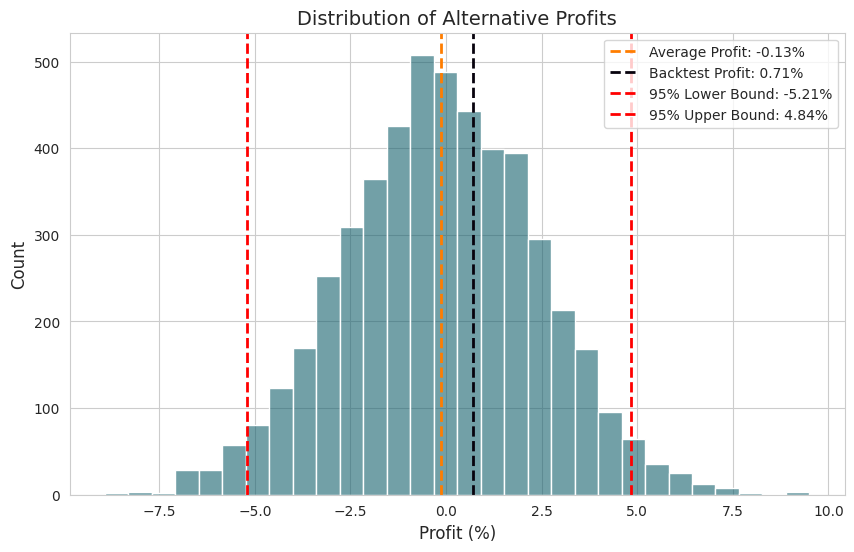


Summary of random effect analysis
  Average profit over simulations: -0.13%
  95% interval of profit: [-5.21%, 4.84]%
  Probability of ending better off than in the backtest: 36.56%
  Probability of ending with a loss: 52.14%


In [92]:
seasons = [i for i in range(2019, 2025)]
always_bet_home(df, seasons)